# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

In [2]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [3]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [4]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [5]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

In [6]:
model = CTGANSynthesizer(epochs=10)

In [7]:
model.fit(df, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

In [8]:
synth_df = model.sample(10000)

In [9]:
synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,2,42,68,85,3.531436,2.919542
1,1,54,66,98,2.476098,2.781902
2,2,43,73,91,2.203752,2.519269
3,2,39,61,89,1.947934,2.595448
4,2,66,74,109,3.147522,2.738095


In [5]:
# Output
synth_output = "./synth_data/ctgan_method.csv"

In [ ]:
synth_df.to_csv(synth_output, sep=",")

## Evaluation

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

### Apparent match distribution privacy metric

In [7]:
def cellchange(df1, df2, quasi, exclude_cols):
    uniques1 = df1.drop_duplicates(subset=quasi, keep=False)
    uniques2 = df2.drop_duplicates(subset=quasi, keep=False)
    matcheduniq = uniques1.merge(uniques2, how='inner', on = quasi)
    allcols = set(df1.columns).intersection(set(df2.columns))
    cols = allcols - set(quasi) - set(exclude_cols)
    print('done with cellchange')
    return match(matcheduniq, cols), uniques1, uniques2, matcheduniq

def match(df, cols):
    S = pd.Series(data=0, index=df.index)
    for c in cols:
        c_x = c + "_x"
        c_y = c + "_y"
        S = S + (df[c_x] == df[c_y]).astype(int)
    S = (S/len(cols))*100
    return S

done with cellchange


(0.0, 100.0)

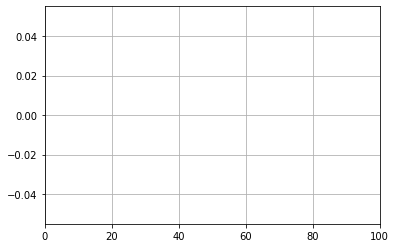

In [15]:
# Quasi identifiers
quasi_cols = [
    "sex"
]

exclude_cols = []

percents, uniques1, uniques2, matched = cellchange(df, synth_df, quasi_cols, exclude_cols)

# Plot it
plt.figure()
percents.hist()
plt.xlim(0, 100)